In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split

def image_directory_to_pandas(image_path):
    """
    Create a pandas DataFrame with image paths and taxonomic labels extracted from a directory structure.

    Parameters:
    ----------
    image_path : str
        The root directory containing subfolders with images.

    Returns:
    -------
    pandas.DataFrame
        A DataFrame containing image paths and label information. Columns include:
        - 'path': The full path to the image.
        - 'folder_label': The folder name, representing the original label (format: 'family_genus_species').
        - 'family': Extracted family name from the folder label.
        - 'genus': Extracted genus name from the folder label.
        - 'species': Combination of genus and species names (e.g., 'genus species').

    Raises:
    ------
    ValueError:
        If the folder label format does not match the expected 'family_genus_species' format.
    """
    labels = []
    paths = []

    # Walk through the directory and collect image paths and labels
    for root_dir, _, filenames in os.walk(image_path):
        for filename in filenames:
            # Ignore hidden files and non-image files
            if filename.startswith('.') or os.path.splitext(filename)[1].lower() not in {".jpeg", ".png", ".jpg"}:
                continue

            # Extract the folder name as the label, ignoring 'GT' directories
            folder_label = os.path.basename(root_dir)
            if folder_label != "GT":
                labels.append(folder_label)
                paths.append(os.path.join(root_dir, filename))

    # Create DataFrame with paths and folder labels
    df = pd.DataFrame({'image_path': paths, 'folder_label': labels})
    df['folder_label'] = df['folder_label'].astype("category")

    # Split the folder_label into 'family', 'genus', and 'species'
    try:
        df[['family', 'genus', 'species']] = df['folder_label'].str.split("_", expand=True)
        df['species'] = df['genus'] + " " + df['species']
    except ValueError as e:
        raise ValueError(
            "Error splitting folder labels. Ensure that your folder structure follows 'family_genus_species' format."
        ) from e

    # Return the dataframe with specified columns
    return df[['image_path', 'folder_label', 'family', 'genus', 'species']]

def split_image_dataframe(df, test_size=0.2, val_size=0.1, random_state=42, stratify_by='folder_label'):
    """
    Split a pandas DataFrame into train, validation, and test sets,
    stratified by the 'folder_name' column.

    Args:
        df (pd.DataFrame): The DataFrame containing image paths and labels.
        test_size (float): Proportion of the dataset to include in the test split.
        val_size (float): Proportion of the dataset to include in the validation split.
        random_state (int): Seed for random number generation for reproducibility.

    Returns:
        tuple: Three pandas DataFrames for train, validation, and test sets.
    """
    # First, split into train+validation and test sets
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df[stratify_by],
        random_state=random_state
    )
    
    # Calculate the adjusted validation size relative to the remaining train+val data
    val_relative_size = val_size / (1 - test_size)
    
    # Split the train+validation set into train and validation sets
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_relative_size,
        stratify=train_val_df[stratify_by],
        random_state=random_state
    )
    
    return train_df, val_df, test_df

def process_image_and_labels(image_path, family, genus, species, family_labels, genus_labels, species_labels, image_size=(224,224)):
    """
    Process an image and its corresponding labels for training.

    Parameters:
    ----------
    image_path : str
        The path to the image file.
    family : str
        The family label of the image.
    genus : str
        The genus label of the image.
    species : str
        The species label of the image.
    family_labels : tf.Tensor
        Tensor of unique family labels.
    genus_labels : tf.Tensor
        Tensor of unique genus labels.
    species_labels : tf.Tensor
        Tensor of unique species labels.

    Returns:
    -------
    img : tf.Tensor
        The processed image tensor.
    labels : dict
        A dictionary containing one-hot encoded labels for family, genus, and species.
    """
    # Load the raw data from the file as a string
    img = tf.io.read_file(image_path)
    # Decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    img = tf.image.resize(img, image_size)
    #img = tf.image.resize_with_pad(img, target_height=image_size[0], target_width=image_size[1])

    # Convert family, genus, and species to indices
    family_label = tf.argmax(tf.equal(family_labels, family))
    genus_label = tf.argmax(tf.equal(genus_labels, genus))
    species_label = tf.argmax(tf.equal(species_labels, species))

    # Convert to one-hot encoded format
    family_label = tf.one_hot(family_label, len(family_labels))
    genus_label = tf.one_hot(genus_label, len(genus_labels))
    species_label = tf.one_hot(species_label, len(species_labels))

    # Return the image and a dictionary of labels with matching keys
    return img, {
        "family": family_label,
        "genus": genus_label,
        "species": species_label
    }

def build_dataset_from_dataframe(df, batch_size=32, image_size=(224,224)):
    """
    Build a TensorFlow dataset from a DataFrame containing image paths and taxonomic labels.

    Parameters:
    ----------
    df : pandas.DataFrame
        DataFrame containing the following columns:
        - 'path': The path to the image.
        - 'Family': The family label of the image.
        - 'Genus': The genus label of the image.
        - 'Species': The species label of the image.
    batch_size : int, optional
        Batch size for training. Default is 32.

    Returns:
    -------
    image_label_ds : tf.data.Dataset
        A TensorFlow dataset with images and one-hot encoded labels.
    family_labels : list
        A sorted list of unique family labels.
    genus_labels : list
        A sorted list of unique genus labels.
    species_labels : list
        A sorted list of unique species labels.
    """
    # Extract the unique family, genus, and species from the dataframe
    family_labels = sorted(df['family'].unique())
    genus_labels = sorted(df['genus'].unique())
    species_labels = sorted(df['species'].unique())

    # Convert family, genus, and species labels to TensorFlow tensors
    family_labels = tf.constant(family_labels)
    genus_labels = tf.constant(genus_labels)
    species_labels = tf.constant(species_labels)

    # Create a TensorFlow dataset from the dataframe's paths and labels
    path_ds = tf.data.Dataset.from_tensor_slices(
        (df['image_path'].values, df['family'].values, df['genus'].values, df['species'].values)
    )

    # Map the processing function to the dataset
    image_label_ds = path_ds.map(
        lambda path, family, genus, species: process_image_and_labels(
            path, family, genus, species, family_labels, genus_labels, species_labels, image_size=image_size
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    # Shuffle, batch, and prefetch the dataset
    image_label_ds = image_label_ds.shuffle(buffer_size=len(df))
    image_label_ds = image_label_ds.batch(batch_size)
    image_label_ds = image_label_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return (
        image_label_ds,
        family_labels.numpy().tolist(),
        genus_labels.numpy().tolist(),
        species_labels.numpy().tolist(),
    )

def predict_image(image_path, model, family_labels, genus_labels, species_labels, image_size=(224,224) ,top_k=3):
    """
    Predict the top-k family, genus, and species from an image using a trained model,
    and display the image with predictions.

    Args:
    - image_path (str): Path to the image file.
    - model (tf.keras.Model): The trained model.
    - family_labels (list): List of family labels.
    - genus_labels (list): List of genus labels.
    - species_labels (list): List of species labels.
    - top_k (int): Number of top predictions to return.

    Returns:
    - top_k_family: List of tuples (family, confidence) for top k family predictions.
    - top_k_genus: List of tuples (genus, confidence) for top k genus predictions.
    - top_k_species: List of tuples (species, confidence) for top k species predictions.
    """

    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = tf.expand_dims(img, 0)  # Add batch dimension

    # Predict family, genus, and species
    family_pred, genus_preds, species_preds = model.predict(img)
    
    # Get top-k predictions for family
    top_k_family_indices = np.argsort(family_pred[0])[-top_k:][::-1]
    top_k_family = [(family_labels[i], family_pred[0][i]) for i in top_k_family_indices]

    # Get top-k predictions for genus
    top_k_genus_indices = np.argsort(genus_preds[0])[-top_k:][::-1]
    top_k_genus = [(genus_labels[i], genus_preds[0][i]) for i in top_k_genus_indices]

    # Get top-k predictions for species
    top_k_species_indices = np.argsort(species_preds[0])[-top_k:][::-1]
    top_k_species = [(species_labels[i], species_preds[0][i]) for i in top_k_species_indices]

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.image.resize(img[0], image_size) / 255.0)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Print top-k predictions for each level
    print("Top 3 Family Predictions:")
    for family, confidence in top_k_family:
        print(f"{family}: {confidence:.4f}")

    print("\nTop 3 Genus Predictions:")
    for genus, confidence in top_k_genus:
        print(f"{genus}: {confidence:.4f}")

    print("\nTop 3 Species Predictions:")
    for species, confidence in top_k_species:
        print(f"{species}: {confidence:.4f}")

    return top_k_family, top_k_genus, top_k_species

def plot_training_history(history, history_fine, fine_tune_at):
    """
    Plot the training history of accuracy and loss for each output.
    
    Args:
    - history (History): History object from the initial training.
    - history_fine (History): History object from the fine-tuning phase.
    - fine_tune_at (int): Epoch at which fine-tuning began.
    """
    # Combine initial training history and fine-tuning history
    accuracy_keys = ['family_accuracy', 'genus_accuracy', 'species_accuracy']
    val_accuracy_keys = ['val_family_accuracy', 'val_genus_accuracy', 'val_species_accuracy']
    loss_keys = ['family_loss', 'genus_loss', 'species_loss']
    val_loss_keys = ['val_family_loss', 'val_genus_loss', 'val_species_loss']

    # Combine the data from the initial training and fine-tuning phases
    combined_history = {}
    for key in accuracy_keys + val_accuracy_keys + loss_keys + val_loss_keys:
        combined_history[key] = history.history.get(key, []) + history_fine.history.get(key, [])

    total_epochs = len(combined_history[accuracy_keys[0]])  # Total number of epochs including fine-tuning
    
    # Create subplots for accuracy and loss
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot accuracy for each output
    for idx, key in enumerate(accuracy_keys):
        axs[0, idx].plot(combined_history[key], label='Training Accuracy')
        axs[0, idx].plot(combined_history[val_accuracy_keys[idx]], label='Validation Accuracy')
        axs[0, idx].axvline(x=fine_tune_at, color='r', linestyle='--', label='Fine-Tuning Start')
        axs[0, idx].set_title(f'{key.replace("_accuracy", "").capitalize()} Accuracy')
        axs[0, idx].set_xlabel('Epochs')
        axs[0, idx].set_ylabel('Accuracy')
        axs[0, idx].legend()
        axs[0, idx].grid(True)
    
    # Plot loss for each output
    for idx, key in enumerate(loss_keys):
        axs[1, idx].plot(combined_history[key], label='Training Loss')
        axs[1, idx].plot(combined_history[val_loss_keys[idx]], label='Validation Loss')
        axs[1, idx].axvline(x=fine_tune_at, color='r', linestyle='--', label='Fine-Tuning Start')
        axs[1, idx].set_title(f'{key.replace("_loss", "").capitalize()} Loss')
        axs[1, idx].set_xlabel('Epochs')
        axs[1, idx].set_ylabel('Loss')
        axs[1, idx].legend()
        axs[1, idx].grid(True)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    

In [3]:
settings = dict(
    batch_size = 128,
    epochs = 10,
    ftun_epochs = 10,
    img_size = (224, 224),
    seed = 42,
    ftun_last_layers = 70,
    ftune_learning_rate = 0.00001,
    
)

df_lab = image_directory_to_pandas("/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/fish_functions/Species_v03")
df_web = image_directory_to_pandas("/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/web/Species_v01")
df_inatlist = image_directory_to_pandas("/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/inaturalist/Species_v02")

df = pd.concat([df_lab, df_web, df_inatlist], ignore_index=True, axis=0)

# find in the species column the values with lass than 50 occurences
counts = df['species'].value_counts()
#df = df[df['species'].isin(counts[counts > 50].index)]

df.head(10)


,image_path,folder_label,family,genus,species
0,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Pomacentridae_Chromis_iomelas,Pomacentridae,Chromis,Chromis iomelas
1,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Pomacentridae_Chromis_iomelas,Pomacentridae,Chromis,Chromis iomelas
2,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Pomacentridae_Chromis_iomelas,Pomacentridae,Chromis,Chromis iomelas
3,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Pomacentridae_Chromis_iomelas,Pomacentridae,Chromis,Chromis iomelas
4,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Pomacentridae_Chromis_iomelas,Pomacentridae,Chromis,Chromis iomelas
5,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Pomacentridae_Chromis_iomelas,Pomacentridae,Chromis,Chromis iomelas
6,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Pomacentridae_Chromis_iomelas,Pomacentridae,Chromis,Chromis iomelas
7,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Pomacentridae_Chromis_iomelas,Pomacentridae,Chromis,Chromis iomelas
8,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Pomacentridae_Chromis_iomelas,Pomacentridae,Chromis,Chromis iomelas
9,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Pomacentridae_Chromis_iomelas,Pomacentridae,Chromis,Chromis iomelas


In [4]:
def get_labels(path):
    
    family_list = []
    genus_list = []
    species_list = []
    
    for folder in os.listdir(path):
        if folder == ".DS_Store":
            continue
        
        family, genus, species = folder.split("_")
        
        family_list.append(family)
        genus_list.append(genus)
        species_list.append(f"{genus} {species}")
        
    return sorted(set(family_list)), sorted(set(genus_list)), sorted(set(species_list))

family_labels, genus_labels, species_labels = get_labels(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset")

len(species_labels)

57

In [5]:
df = df[df['species'].isin(species_labels)]

df.head(10)

,image_path,folder_label,family,genus,species
57,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Labridae_Halichoeres_claudia,Labridae,Halichoeres,Halichoeres claudia
58,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Labridae_Halichoeres_claudia,Labridae,Halichoeres,Halichoeres claudia
59,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Labridae_Halichoeres_claudia,Labridae,Halichoeres,Halichoeres claudia
60,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Labridae_Halichoeres_claudia,Labridae,Halichoeres,Halichoeres claudia
61,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Labridae_Halichoeres_claudia,Labridae,Halichoeres,Halichoeres claudia
62,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Labridae_Halichoeres_claudia,Labridae,Halichoeres,Halichoeres claudia
63,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Labridae_Halichoeres_claudia,Labridae,Halichoeres,Halichoeres claudia
64,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Labridae_Halichoeres_claudia,Labridae,Halichoeres,Halichoeres claudia
65,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Labridae_Halichoeres_claudia,Labridae,Halichoeres,Halichoeres claudia
66,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Labridae_Halichoeres_claudia,Labridae,Halichoeres,Halichoeres claudia


In [6]:
train_df, val_df, test_df = split_image_dataframe(df, test_size=0.15, val_size=0.15, stratify_by='folder_label')

# Display the sizes of each split
print(f"Training Sample size: {len(train_df)}")
print(f"Validation Sample size: {len(val_df)}")
print(f"Test Sample size: {len(test_df)}")

train_ds, family_labels, genus_labels, species_labels = build_dataset_from_dataframe(train_df, settings['batch_size'], settings['img_size'])  
val_ds, _, _, _ = build_dataset_from_dataframe(val_df, settings['batch_size'], settings['img_size'])
test_ds, _, _, _ = build_dataset_from_dataframe(test_df, settings['batch_size'], settings['img_size'])

Training Sample size: 10944
Validation Sample size: 2346
Test Sample size: 2346


2025-01-06 17:51:00.286048: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-01-06 17:51:00.286091: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-01-06 17:51:00.286103: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-01-06 17:51:00.286126: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-06 17:51:00.286145: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
train_df['species'].nunique()

57

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
# Data Augmentation Function
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
    ]
)

2025-01-06 12:08:41.067695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3068 of 10944
2025-01-06 12:09:01.077708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9143 of 10944
2025-01-06 12:09:07.072759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-06 12:09:07.777098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-06 12:09:08.595555: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


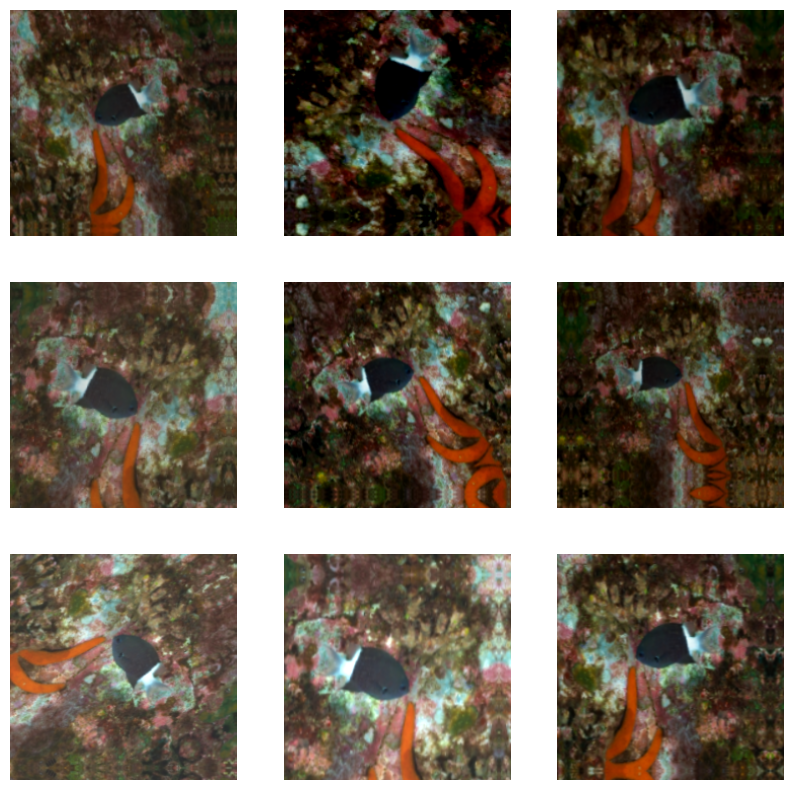

In [10]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import ( # type: ignore
    Dense, GlobalAveragePooling2D, Dropout,
    BatchNormalization, Activation, Multiply,
    Add, Concatenate, Input, Reshape, Layer, Attention, MultiHeadAttention
)

from tensorflow.keras import backend as K                                                       # type: ignore
from tensorflow.keras.models import Model                                                       # type: ignore
from tensorflow.keras.applications import ResNet50V2                                            # type: ignore
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess       # type: ignore


def phorcys(
    n_families, 
    n_genera, 
    n_species,
    attention=False, 
    input_shape=(224,224,3), 
    base_weights="imagenet", 
    base_trainable=False, 
    augmentation_layer=None,
    shared_layer_neurons=512,
    shared_layer_dropout=0.3,
    genus_hidden_neurons=512,
    specie_hidden_neurons=512,
    num_heads=4,
):
    
    # Base Model
    base_model = ResNet50V2(include_top=False, weights=base_weights, input_shape=input_shape)
    base_model.trainable = base_trainable

    # Input and data augmentation layers
    inputs = Input(shape=input_shape)
    x = augmentation_layer(inputs) if augmentation_layer else inputs  
    x = resnet_preprocess(x)  
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    
    # Shared dense layer for better feature learning
    shared_layer = tf.keras.layers.Dense(shared_layer_neurons, activation=None, name='shared_layer')(x)
    shared_layer = BatchNormalization()(shared_layer)
    shared_layer = Activation('relu')(shared_layer)
    
    # Attention Layer
    if attention:
        shared_layer_reshaped = Reshape((1, shared_layer_neurons))(shared_layer)
        if attention == "mha":
            attention_output = MultiHeadAttention(
                num_heads=num_heads, 
                key_dim=shared_layer_neurons
            )(shared_layer_reshaped, shared_layer_reshaped)
        else:
            attention_output = Attention()([shared_layer_reshaped, shared_layer_reshaped])
        attention_output = Reshape((shared_layer_neurons,))(attention_output)  # Reshape back to 2D
        shared_layer = Add()([shared_layer, attention_output])  # Residual connection
    
    shared_layer = Dropout(shared_layer_dropout)(shared_layer)

    # Define family output
    family_output = tf.keras.layers.Dense(n_families, activation='softmax', name='family')(shared_layer)

    # Concatenate the family output with the base model output
    family_features = tf.keras.layers.Concatenate()([shared_layer, family_output])

    # Define genus output, using family features as additional input
    genus_hidden = tf.keras.layers.Dense(genus_hidden_neurons, activation='relu')(family_features)
    genus_output = tf.keras.layers.Dense(n_genera, activation='softmax', name='genus')(genus_hidden)

    # Concatenate the family and genus outputs with the base model output
    genus_features = tf.keras.layers.Concatenate()([shared_layer, family_output, genus_output])

    # Define species output, using both family and genus features as additional input
    species_hidden = tf.keras.layers.Dense(specie_hidden_neurons, activation='relu')(genus_features)
    species_output = tf.keras.layers.Dense(n_species, activation='softmax', name='species')(species_hidden)

    # Create the hierarchical model
    model = tf.keras.Model(inputs, [family_output, genus_output, species_output])
    
    return model

model = phorcys(
    n_families=len(family_labels),
    n_genera=len(genus_labels),
    n_species=len(species_labels),
    input_shape=(224,224,3),
    augmentation_layer=data_augmentation,
    shared_layer_neurons=1024,
    shared_layer_dropout=0.2,
    genus_hidden_neurons=256,
    specie_hidden_neurons=256,
    attention=False
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss = 'categorical_focal_crossentropy',
    metrics = {
        'family': ["accuracy", "AUC", "Precision", "Recall"],
        'genus': ["accuracy", "AUC", "Precision", "Recall"],
        'species': ["accuracy", "AUC", "Precision", "Recall"],
    },
    loss_weights={
        "family": 1.0,
        "genus": 1.5,
        "species": 1.8,
    }
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide         │ (None, 224, 224,  │          0 │ sequential[0][0]  │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 224, 224,  │          0 │ true_divide[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 7, 7,      │ 23,564,800 │ subtract[0][0]    │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50v2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_layer        │ (None, 1024)      │  2,098,176 │ global_average_p… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024)      │      4,096 │ shared_layer[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1024)      │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ family (Dense)      │ (None, 18)        │     18,450 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1042)      │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ family[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    267,008 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genus (Dense)       │ (None, 45)        │     11,565 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1087)      │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ family[0][0],     │
│                     │                   │            │ genus[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    278,528 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species (Dense)     │ (None, 57)        │     14,649 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,257,272 (100.16 MB)

 Trainable params: 2,690,424 (10.26 MB)

 Non-trainable params: 23,566,848 (89.90 MB)

In [12]:
from tqdm import tqdm
from tensorflow.keras.callbacks import Callback
from loguru import logger
from colorama import Fore, Style, init

# Initialize colorama for Windows compatibility
#init(autoreset=True)

def colorize_accuracy(value):
    if value < 0.75:
        return Fore.RED + f"{value:.4f}" + Style.RESET_ALL
    elif 0.75 <= value < 0.85:
        return Fore.YELLOW + f"{value:.4f}" + Style.RESET_ALL
    elif 0.85 <= value < 0.92:
        return Fore.GREEN + f"{value:.4f}" + Style.RESET_ALL
    else:
        return Fore.MAGENTA + f"{value:.4f}" + Style.RESET_ALL

class TQDMProgressBar(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_bar = tqdm(total=self.params['steps'], 
                              desc=f"Epoch {epoch+1}/{self.params['epochs']}", 
                              unit="batch", 
                              dynamic_ncols=True)

    def on_batch_end(self, batch, logs=None):
        self.epoch_bar.update(1)
        # Update the progress bar for every 10 batches to reduce terminal clutter
        if batch % 10 == 0 or batch == self.params['steps'] - 1:
            self.epoch_bar.set_postfix({
                'loss': f"{logs['loss']:.4f}",
                'family_acc': f"{logs.get('family_accuracy', 0):.4f}",
                'genus_acc': f"{logs.get('genus_accuracy', 0):.4f}",
                'species_acc': f"{logs.get('species_accuracy', 0):.4f}",
            })

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_bar.close()

        val_family_acc = logs.get('val_family_accuracy', 0)
        val_genus_acc = logs.get('val_genus_accuracy', 0)
        val_species_acc = logs.get('val_species_accuracy', 0)

        val_family_acc_colored = colorize_accuracy(val_family_acc)
        val_genus_acc_colored = colorize_accuracy(val_genus_acc)
        val_species_acc_colored = colorize_accuracy(val_species_acc)

        summary_message = (
            f"Epoch {epoch+1} completed - Loss: {logs['loss']:.4f}, "
            f"Val Family Accuracy: {val_family_acc_colored}, "
            f"Val Genus Accuracy: {val_genus_acc_colored}, "
            f"Val Species Accuracy: {val_species_acc_colored}"
        )
        #tqdm.write(summary_message)  # Write without interfering with progress bar
        logger.info(summary_message)

# Integrating the callback
callbacks = [
    TQDMProgressBar(),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
]


In [12]:
results = model.evaluate(test_ds, return_dict=True)

print(f"""
            -- Report for HACPL-MO Classifier --\n
Family Accuracy: {results['family_accuracy']:.3f} / Loss: {results['family_loss']:.3f}\n
Genus Accuracy: {results['genus_accuracy']:.3f} / Loss: {results['genus_loss']:.3f}\n
Species Accuracy: {results['species_accuracy']:.3f} / Loss: {results['species_loss']:.3f}

""")

2025-01-06 15:10:26.975517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 550ms/step - family_AUC: 0.4932 - family_Precision: 0.0086 - family_Recall: 1.3776e-04 - family_accuracy: 0.0787 - family_loss: 0.7682 - genus_AUC: 0.4607 - genus_Precision: 0.0000e+00 - genus_Recall: 0.0000e+00 - genus_accuracy: 0.0061 - genus_loss: 1.5228 - loss: 4.2582 - species_AUC: 0.4693 - species_Precision: 0.0000e+00 - species_Recall: 0.0000e+00 - species_accuracy: 0.0130 - species_loss: 1.9675

            -- Report for HACPL-MO Classifier --

Family Accuracy: 0.079 / Loss: 0.770

Genus Accuracy: 0.008 / Loss: 1.518

Species Accuracy: 0.015 / Loss: 1.954




In [13]:
history = model.fit(
    train_ds,
    epochs=settings['epochs'],
    validation_data=val_ds,
    batch_size=settings['batch_size'],
    callbacks=callbacks,
    verbose=0  # Suppress TensorFlow default output
)

Epoch 1/10:   0%|          | 0/86 [00:00<?, ?batch/s]2025-01-06 15:11:05.111165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3002 of 10944
2025-01-06 15:11:25.098606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8856 of 10944
2025-01-06 15:11:32.517570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-06 15:11:34.335285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 1/10: 100%|██████████| 86/86 [02:03<00:00,  1.43s/batch, loss=2.6017, family_acc=0.4380, genus_acc=0.3267, species_acc=0.2810] 
2025-01-06 15:12:53.486 | INFO     | __main__:on_epoch_end:55 - Epoch 1 completed - Loss: 2.6017, Val Family Accuracy: 0.6556, Val Genus Accuracy: 0.5673, Val Species Accuracy: 0.5362
Epoch 2/10: 100%|██████████| 86/86 [01:17<00:00,  1.12batch/s, loss=1

In [13]:
history = model.fit(
    train_ds,
    epochs=settings['epochs'],
    validation_data=val_ds,
    batch_size=settings['batch_size'],
    callbacks=callbacks,
    verbose=0  # Suppress TensorFlow default output
)

Epoch 1/10:   0%|          | 0/86 [00:00<?, ?batch/s]2025-01-06 17:51:37.533535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-01-06 17:51:50.408444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3312 of 10944
2025-01-06 17:52:10.399687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9961 of 10944
2025-01-06 17:52:13.358092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-06 17:52:14.185164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 1/10: 100%|██████████| 86/86 [01:59<00:00,  1.39s/batch, loss=2.6035, family_acc=0.4316, genus_acc=0.3207, species_acc=0.2696]
2025-01-06 17:53:35.212 | INFO     | __main__:on_epoch_end:55 - Epoch 1 completed - Loss: 2.6035, V

In [14]:
results = model.evaluate(test_ds, return_dict=True)

print(f"""
            -- Report for HACPL-MO Classifier --\n
Family Accuracy: {results['family_accuracy']:.3f} / Loss: {results['family_loss']:.3f}\n
Genus Accuracy: {results['genus_accuracy']:.3f} / Loss: {results['genus_loss']:.3f}\n
Species Accuracy: {results['species_accuracy']:.3f} / Loss: {results['species_loss']:.3f}

""")

19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 522ms/step - family_AUC: 0.9911 - family_Precision: 0.9256 - family_Recall: 0.7382 - family_accuracy: 0.8498 - family_loss: 0.0744 - genus_AUC: 0.9908 - genus_Precision: 0.9262 - genus_Recall: 0.7349 - genus_accuracy: 0.8131 - genus_loss: 0.1632 - loss: 0.4405 - species_AUC: 0.9918 - species_Precision: 0.9487 - species_Recall: 0.7310 - species_accuracy: 0.8254 - species_loss: 0.2027

            -- Report for HACPL-MO Classifier --

Family Accuracy: 0.856 / Loss: 0.070

Genus Accuracy: 0.827 / Loss: 0.148

Species Accuracy: 0.836 / Loss: 0.186




In [14]:
results = model.evaluate(test_ds, return_dict=True)

print(f"""
            -- Report for HACPL-MO Classifier --\n
Family Accuracy: {results['family_accuracy']:.3f} / Loss: {results['family_loss']:.3f}\n
Genus Accuracy: {results['genus_accuracy']:.3f} / Loss: {results['genus_loss']:.3f}\n
Species Accuracy: {results['species_accuracy']:.3f} / Loss: {results['species_loss']:.3f}

""")

19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 523ms/step - family_AUC: 0.9925 - family_Precision: 0.9435 - family_Recall: 0.7673 - family_accuracy: 0.8642 - family_loss: 0.0647 - genus_AUC: 0.9926 - genus_Precision: 0.9417 - genus_Recall: 0.7635 - genus_accuracy: 0.8286 - genus_loss: 0.1369 - loss: 0.3877 - species_AUC: 0.9923 - species_Precision: 0.9441 - species_Recall: 0.7370 - species_accuracy: 0.8367 - species_loss: 0.1868

            -- Report for HACPL-MO Classifier --

Family Accuracy: 0.853 / Loss: 0.071

Genus Accuracy: 0.821 / Loss: 0.149

Species Accuracy: 0.823 / Loss: 0.203




In [15]:
# Fine-tuning
base_model = model.layers[2]

base_model.trainable = True
for layer in base_model.layers[:-settings['ftun_last_layers']]:
    layer.trainable = False
    
print(f"Unfreezing the last {settings['ftun_last_layers']} layers")

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=settings['ftune_learning_rate']),
    loss = 'categorical_focal_crossentropy',
    metrics = {
        'family': ["accuracy", "AUC", "Precision", "Recall"],
        'genus': ["accuracy", "AUC", "Precision", "Recall"],
        'species': ["accuracy", "AUC", "Precision", "Recall"],
    },
    loss_weights={
        "family": 1.0,
        "genus": 0.8,
        "species": 0.6,
    }
)

Unfreezing the last 70 layers


In [16]:
total_epochs =  settings['epochs'] + settings['ftun_epochs']

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=len(history.epoch),
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=0  # Suppress TensorFlow default output
)

Epoch 11/20: 100%|██████████| 86/86 [02:10<00:00,  1.51s/batch, loss=0.2978, family_acc=0.7836, genus_acc=0.7822, species_acc=0.7658]
2025-01-06 15:29:29.947 | INFO     | __main__:on_epoch_end:55 - Epoch 11 completed - Loss: 0.2978, Val Family Accuracy: 0.8508, Val Genus Accuracy: 0.8308, Val Species Accuracy: 0.8210
Epoch 12/20: 100%|██████████| 86/86 [01:54<00:00,  1.33s/batch, loss=0.2337, family_acc=0.8253, genus_acc=0.8181, species_acc=0.8083]
2025-01-06 15:31:24.022 | INFO     | __main__:on_epoch_end:55 - Epoch 12 completed - Loss: 0.2337, Val Family Accuracy: 0.8551, Val Genus Accuracy: 0.8316, Val Species Accuracy: 0.8286
Epoch 13/20: 100%|██████████| 86/86 [01:58<00:00,  1.37s/batch, loss=0.2090, family_acc=0.8415, genus_acc=0.8368, species_acc=0.8287]
2025-01-06 15:33:22.095 | INFO     | __main__:on_epoch_end:55 - Epoch 13 completed - Loss: 0.2090, Val Family Accuracy: 0.8640, Val Genus Accuracy: 0.8346, Val Species Accuracy: 0.8321
Epoch 14/20: 100%|██████████| 86/86 [01:53<

In [17]:
results = model.evaluate(test_ds, return_dict=True)

print(f"""
            -- Report for HACPL-MO Classifier --\n
Family Accuracy: {results['family_accuracy']:.3f} / Loss: {results['family_loss']:.3f}\n
Genus Accuracy: {results['genus_accuracy']:.3f} / Loss: {results['genus_loss']:.3f}\n
Species Accuracy: {results['species_accuracy']:.3f} / Loss: {results['species_loss']:.3f}

""")

19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 554ms/step - family_AUC: 0.9939 - family_Precision: 0.9372 - family_Recall: 0.8537 - family_accuracy: 0.8940 - family_loss: 0.0530 - genus_AUC: 0.9939 - genus_Precision: 0.9364 - genus_Recall: 0.8263 - genus_accuracy: 0.8696 - genus_loss: 0.0591 - loss: 0.1602 - species_AUC: 0.9937 - species_Precision: 0.9384 - species_Recall: 0.8194 - species_accuracy: 0.8691 - species_loss: 0.0478

            -- Report for HACPL-MO Classifier --

Family Accuracy: 0.901 / Loss: 0.047

Genus Accuracy: 0.874 / Loss: 0.055

Species Accuracy: 0.871 / Loss: 0.046




1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


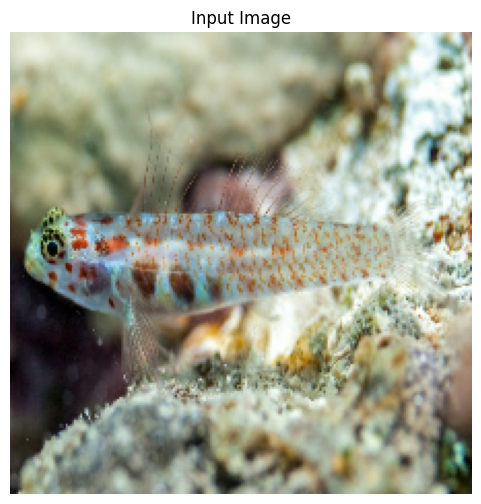

Top 3 Family Predictions:
b'Gobiidae': 0.8508
b'Tripterygiidae': 0.1355
b'Apogonidae': 0.0035
b'Blenniidae': 0.0027
b'Creediidae': 0.0027

Top 3 Genus Predictions:
b'Eviota': 0.7990
b'Fusigobius': 0.0780
b'Ucla': 0.0522
b'Enneapterygius': 0.0266
b'Istigobius': 0.0116

Top 3 Species Predictions:
b'Eviota melasma': 0.2534
b'Fusigobius neophytus': 0.2094
b'Eviota albolineata': 0.1887
b'Ucla xenogrammus': 0.1441
b'Helcogramma fuscopinna': 0.0592


In [18]:
image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset/Gobiidae_Eviota_melasma/web_Eviota_melasma_41.jpeg'

top_k_family, top_k_genus, top_k_species = predict_image(
    image_path, model, family_labels, genus_labels, species_labels, top_k=5, image_size=settings['img_size']
)

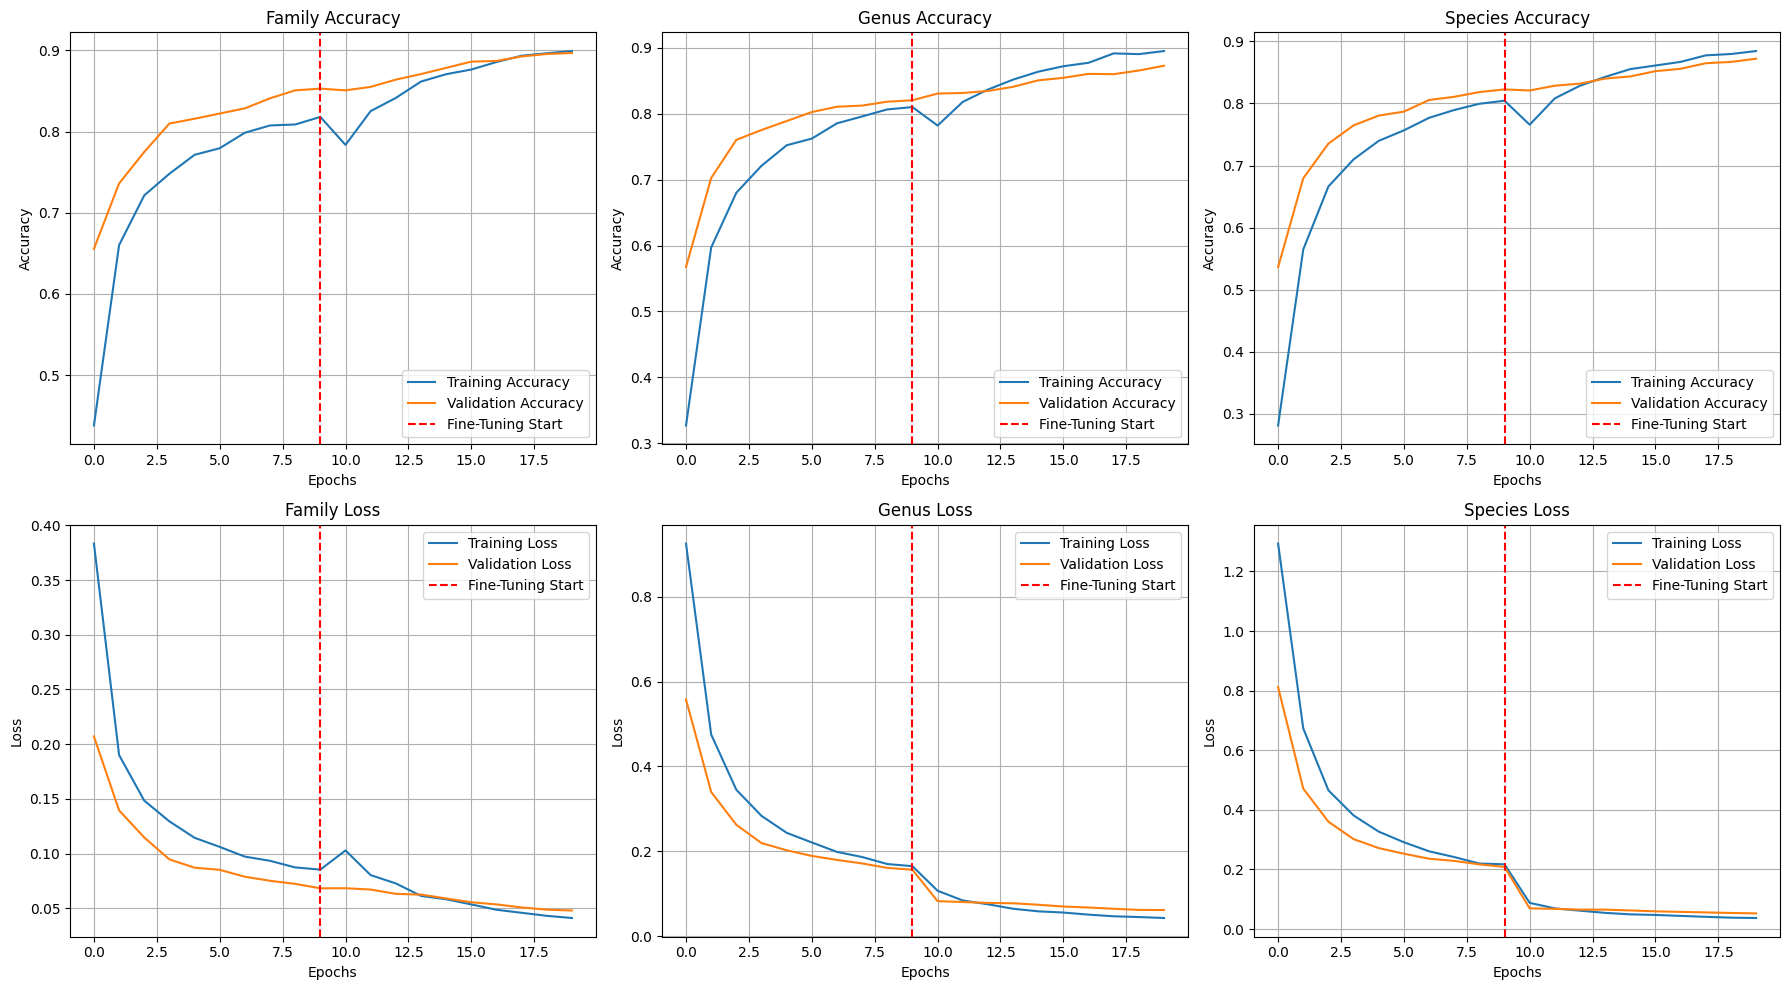

In [19]:
plot_training_history(history, history_fine, fine_tune_at=settings['epochs']-1)

In [21]:
import os
import numpy as np
from collections import defaultdict
import pandas as pd
import tensorflow as tf

def get_taxonomic_mappings_from_folders(data_dir):
    """
    Extract family, genus, and species mappings from the dataset folder structure.
    
    Args:
    - data_dir (str): Path to the training dataset directory.
    
    Returns:
    - family_labels (list): List of unique family names.
    - genus_labels (list): List of unique genus names.
    - species_labels (list): List of unique species names.
    - genus_to_family (dict): Mapping of genus to family.
    - species_to_genus (dict): Mapping of species to genus.
    """
    family_labels = set()
    genus_labels = set()
    species_labels = set()
    genus_to_family = {}
    species_to_genus = {}

    # Iterate through the folders in the data directory
    for folder_name in os.listdir(data_dir):
        # Assume folder names are in the format "family_genus_species"
        parts = folder_name.split('_')
        if len(parts) == 3:
            family, genus, species = parts
            family_labels.add(family)
            genus_labels.add(genus)
            species_full = f"{genus}_{species}"
            species_labels.add(species_full)

            # Map genus to family
            genus_to_family[genus] = family

            # Map species to genus
            species_to_genus[species_full] = genus

    # Sort the labels to maintain consistent ordering
    family_labels = sorted(list(family_labels))
    genus_labels = sorted(list(genus_labels))
    species_labels = sorted(list(species_labels))

    return family_labels, genus_labels, species_labels, genus_to_family, species_to_genus

def analyze_taxonomic_misclassifications(model, dataset, family_labels, genus_labels, species_labels, genus_to_family, species_to_genus):
    """
    Analyze misclassifications of a trained model to check if taxonomic hierarchies are respected.
    
    Args:
    - model (tf.keras.Model): The trained model.
    - dataset (tf.data.Dataset): Validation or test dataset.
    - family_labels, genus_labels, species_labels (list): List of class labels for family, genus, and species.
    - genus_to_family (dict): Mapping of genus to family.
    - species_to_genus (dict): Mapping of species to genus.
    
    Returns:
    - summary (dict): A dictionary containing summary of misclassifications.
    - genus_df (DataFrame): DataFrame with genus misclassification details.
    - species_df (DataFrame): DataFrame with species misclassification details.
    """
    # Counters for misclassifications
    genus_misclassifications = defaultdict(int)
    genus_respect_family = 0
    genus_total_mistakes = 0

    species_misclassifications = defaultdict(int)
    species_respect_genus = 0
    species_respect_family = 0
    species_total_mistakes = 0

    # Iterate over the dataset to collect predictions and true labels
    for images, labels in dataset:
        # Get the logits from the model for each output (family, genus, species)
        family_logits, genus_logits, species_logits = model(images, training=False)

        # Get true and predicted labels for each level
        true_family_indices = tf.argmax(labels['family'], axis=1).numpy()
        true_genus_indices = tf.argmax(labels['genus'], axis=1).numpy()
        true_species_indices = tf.argmax(labels['species'], axis=1).numpy()

        pred_family_indices = np.argmax(family_logits, axis=1)
        pred_genus_indices = np.argmax(genus_logits, axis=1)
        pred_species_indices = np.argmax(species_logits, axis=1)

        # Analyze genus misclassifications
        for true_genus_idx, pred_genus_idx in zip(true_genus_indices, pred_genus_indices):
            if true_genus_idx != pred_genus_idx:
                genus_total_mistakes += 1
                true_genus = genus_labels[true_genus_idx]
                pred_genus = genus_labels[pred_genus_idx]

                # Count the misclassification
                genus_misclassifications[(true_genus, pred_genus)] += 1

                # Check if the misclassified genus is in the same family
                true_family = genus_to_family[true_genus]
                pred_family = genus_to_family.get(pred_genus, None)  # Use .get() in case pred_genus is missing
                if true_family == pred_family:
                    genus_respect_family += 1

        # Analyze species misclassifications
        for true_species_idx, pred_species_idx in zip(true_species_indices, pred_species_indices):
            if true_species_idx != pred_species_idx:
                species_total_mistakes += 1
                true_species = species_labels[true_species_idx]
                pred_species = species_labels[pred_species_idx]

                # Count the misclassification
                species_misclassifications[(true_species, pred_species)] += 1

                # Check if the misclassified species is in the same genus
                true_genus = species_to_genus[true_species]
                pred_genus = species_to_genus.get(pred_species, None)
                if true_genus == pred_genus:
                    species_respect_genus += 1

                # Check if the misclassified species is in the same family
                true_family = genus_to_family[true_genus]
                pred_family = genus_to_family.get(pred_genus, None)
                if true_family == pred_family:
                    species_respect_family += 1

    # Calculate percentages of misclassifications that respect the hierarchy
    genus_hierarchy_respect_pct = (genus_respect_family / genus_total_mistakes) * 100 if genus_total_mistakes > 0 else 0
    species_hierarchy_respect_genus_pct = (species_respect_genus / species_total_mistakes) * 100 if species_total_mistakes > 0 else 0
    species_hierarchy_respect_family_pct = (species_respect_family / species_total_mistakes) * 100 if species_total_mistakes > 0 else 0

    # Create a summary of the analysis
    summary = {
        'genus_total_mistakes': genus_total_mistakes,
        'genus_hierarchy_respect': genus_respect_family,
        'genus_hierarchy_respect_pct': genus_hierarchy_respect_pct,
        'genus_misclassifications': dict(genus_misclassifications),
        'species_total_mistakes': species_total_mistakes,
        'species_hierarchy_respect_genus': species_respect_genus,
        'species_hierarchy_respect_genus_pct': species_hierarchy_respect_genus_pct,
        'species_hierarchy_respect_family': species_respect_family,
        'species_hierarchy_respect_family_pct': species_hierarchy_respect_family_pct,
        'species_misclassifications': dict(species_misclassifications),
    }

    # Convert misclassification dictionaries to DataFrames for better readability
    genus_df = pd.DataFrame(
        [(true, pred, count) for (true, pred), count in genus_misclassifications.items()],
        columns=['True Genus', 'Predicted Genus', 'Count']
    ).sort_values(by='Count', ascending=False)

    species_df = pd.DataFrame(
        [(true, pred, count) for (true, pred), count in species_misclassifications.items()],
        columns=['True Species', 'Predicted Species', 'Count']
    ).sort_values(by='Count', ascending=False)

    # Print the summaries
    print(f"Genus Misclassifications: {genus_total_mistakes}")
    print(f"Genus Misclassifications Respecting Family: {genus_respect_family} ({genus_hierarchy_respect_pct:.2f}%)")
    print(f"\nTop Genus Misclassifications:\n{genus_df.head(10)}")

    print(f"\nSpecies Misclassifications: {species_total_mistakes}")
    print(f"Species Misclassifications Respecting Genus: {species_respect_genus} ({species_hierarchy_respect_genus_pct:.2f}%)")
    print(f"Species Misclassifications Respecting Family: {species_respect_family} ({species_hierarchy_respect_family_pct:.2f}%)")
    print(f"\nTop Species Misclassifications:\n{species_df.head(10)}")

    return summary, genus_df, species_df

# Example usage:
# Assuming 'train_dir' is the path to the training dataset directory.
train_dir = "/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset"
family_labels, genus_labels, species_labels, genus_to_family, species_to_genus = get_taxonomic_mappings_from_folders(train_dir)

# Now analyze the misclassifications using the mappings
summary, genus_df, species_df = analyze_taxonomic_misclassifications(
    model=model,
    dataset=test_ds,
    family_labels=family_labels,
    genus_labels=genus_labels,
    species_labels=species_labels,
    genus_to_family=genus_to_family,
    species_to_genus=species_to_genus
)

2025-01-06 15:52:09.968484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 1962 of 2346
2025-01-06 15:52:11.923133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


Genus Misclassifications: 296
Genus Misclassifications Respecting Family: 86 (29.05%)

Top Genus Misclassifications:
         True Genus  Predicted Genus  Count
3        Fusigobius       Istigobius     10
48       Istigobius       Fusigobius      6
52     Ostorhinchus  Pseudocheilinus      6
14   Enneapterygius             Ucla      5
91          Chromis      Pomacentrus      5
71   Enneapterygius      Helcogramma      4
9     Sebastapistes     Scorpaenodes      4
49  Pseudocheilinus     Ostorhinchus      3
36  Pseudocheilinus    Paracirrhites      3
62    Nemateleotris          Chromis      3

Species Misclassifications: 302
Species Misclassifications Respecting Genus: 30 (9.93%)
Species Misclassifications Respecting Family: 101 (33.44%)

Top Species Misclassifications:
                   True Species            Predicted Species  Count
13         Istigobius_decoratus         Fusigobius_neophytus      8
9          Fusigobius_neophytus         Istigobius_decoratus      7
12        Seba

2025-01-06 15:52:27.935768: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
